# <span style="color:#DC143C">NCF with Side Information (실험 2: Concatenation 방식 조합 분석) </span>
* 목표: Concatenation 방식에서 최적의 Side Info 조합 찾기
* 실험방법
  * 모든 조합에 Concatenation 방식 사용 (통제)
  * 실험 1과 동일한 7가지 조합
    * 케이스1 : Item+Category
    * 케이스2 : Item+Author
    * 케이스3 : Item+Publisher
    * 케이스4 : Item++Category+Author
    * 케이스5 : Item++Category+Publisher
    * 케이스6 : Item++Author+Publisher
    * 케이스7 : Item++Category+Author+Publisher(Full)
* Addition 방식
  * enriched=item_emb+selected_side_info_embs

* 구글 드라이브 마운트

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 0. 공통 설정 및 라이브러리 Imports

In [2]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score # 성능 평가
import sys
import warnings; warnings.filterwarnings("ignore")

In [3]:
def set_seed(seed=42):
    """
    실행 결과의 재현성(Reproducibility)을 보장하기 위해 난수 시드를 고정합니다.
    시드를 고정하면 코드를 다시 실행해도 동일한 결과를 얻을 수 있습니다.
    """
    # 1. Python 기본 random 모듈 시드 고정
    random.seed(seed)
    # 2. NumPy 시드 고정
    np.random.seed(seed)
    # 3. PyTorch CPU 연산 시드 고정
    torch.manual_seed(seed)
    # 4. CUDA (GPU) 사용 시 추가 시드 고정 및 설정
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        # cuDNN 관련 설정으로, GPU 연산의 비결정성을 줄여줍니다.
        # 연산 속도가 다소 느려질 수 있지만, 재현성을 높여줍니다.
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

# 전역적으로 시드 고정 (재현성 확보)
SEED = 42
set_seed(SEED)

# 학습/추론에 사용할 디바이스 선택
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"사용 디바이스: {device}")

사용 디바이스: cuda


In [4]:
# --- 임베딩 차원 설정 (Addition 방식은 모든 차원 통일 필요) ---
EMBED_DIM = 8  # 실험 1,2,3 (실험 4 제외)

# --- NCF 모델 구조 관련 ---
GMF_DIM = EMBED_DIM   # GMF 경로 차원
MLP_DIM = EMBED_DIM   # 모든 실험 고정
MLP_LAYERS = [64, 32, 16, 8]

# --- 학습 관련 ---
BATCH_SIZE = 128
EPOCHS = 20 # Early Stopping 사용
LR = 1e-4
DROPOUT_RATE = 0.3
PATIENCE = 3 # Early Stopping

# --- 추천 및 평가 관련 ---
TOP_K = 10 # NDCG@10 계산용
# TEST_USERS = 100

### 1. 데이터 준비

In [5]:
from re import A



def prepare_train_df(use_category_id, use_author_id, use_publisher_id) :
    global train_df, test_df
    global M, N, NUM_CATEGORIES, NUM_AUTHORS, NUM_PUBLISHERS
    global all_item_meta

    # 학습 데이터 로드 및 기본 정보 확인

    # pickle 파일 구조: [train_df, test_df, train_item_meta, test_item_meta]
    # - train_df, test_df: USER, ITEM, RATING 컬럼만 포함
    # - train_item_meta, test_item_meta: ITEM, category_id, author_id, publisher_id 포함
    train_df, test_df, train_item_meta, test_item_meta = pd.read_pickle('/content/drive/MyDrive/4학기/추천시스템/실습-20251011/개인과제/book_train_test_1v3.pkl')

    # 전체 데이터 기준으로 M, N 계산 (첫 번째 NCF-pure와 동일한 방식)
    all_data = pd.concat([train_df, test_df])
    M = all_data['USER'].max() + 1   # Number of users
    N = all_data['ITEM'].max() + 1   # Number of items

    # Side info 개수도 전체 기준으로 계산: train과 test의 item_meta를 합쳐서 전체 unique 값의 개수를 구함
    all_item_meta = pd.concat([train_item_meta, test_item_meta]).drop_duplicates('ITEM')
    NUM_CATEGORIES = all_item_meta['category_id'].max() + 1
    NUM_AUTHORS = all_item_meta['author_id'].max() + 1
    NUM_PUBLISHERS = all_item_meta['publisher_id'].max() + 1
    print(f"총 사용자 수 (M): {M}, 총 아이템 수 (N): {N}")
    print(f"카테고리 수: {NUM_CATEGORIES}, 작가 수: {NUM_AUTHORS}, 출판사 수: {NUM_PUBLISHERS}")

    # Side info를 train_df에 병합 및 결측치 처리(혹시 매칭 안 되는 아이템이 있을 경우 0으로 채움)
    train_df = train_df.merge(train_item_meta, on='ITEM', how='left')
    train_df[['category_id', 'author_id', 'publisher_id']] = train_df[['category_id', 'author_id', 'publisher_id']].fillna(0).astype(int)

    columns_to_drop = []
    if not use_category_id :
        columns_to_drop.append('category_id')
    if not use_author_id :
        columns_to_drop.append('author_id')
    if not use_publisher_id :
        columns_to_drop.append('publisher_id')
    if columns_to_drop:
        train_df = train_df.drop(columns=columns_to_drop)

    train_df.head()

    print(f"Train Data Column List [{train_df.columns.tolist()}]")

In [6]:
# 데이터 준비: NCF Dataset 클래스 정의

class NCFDataset(Dataset):
    """
    NCF 학습을 위한 PyTorch Dataset 클래스
    Side information을 포함합니다
    """
    def __init__(self, df):
        self.users = torch.tensor(df['USER'].values, dtype=torch.long)
        self.items = torch.tensor(df['ITEM'].values, dtype=torch.long)
        self.ratings = torch.tensor(df['RATING'].values, dtype=torch.float32)

        # Side info 추가
        if 'category_id' in df.columns:
            self.categories = torch.tensor(df['category_id'].values, dtype=torch.long)

        if 'author_id' in df.columns:
            self.authors = torch.tensor(df['author_id'].values, dtype=torch.long)

        if 'publisher_id' in df.columns:
            self.publishers = torch.tensor(df['publisher_id'].values, dtype=torch.long)

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):
        result = [self.users[idx], self.items[idx]]

        if hasattr(self, 'categories'):
            result.append(self.categories[idx])
        else:
            result.append(torch.tensor(-1, dtype=torch.long))

        if hasattr(self, 'authors'):
            result.append(self.authors[idx])
        else:
            result.append(torch.tensor(-1, dtype=torch.long))

        if hasattr(self, 'publishers'):
            result.append(self.publishers[idx])
        else:
            result.append(torch.tensor(-1, dtype=torch.long))

        result.append(self.ratings[idx])

        return tuple(result)

### 2. NCF 모델 정의

**NCF의 핵심 아이디어:**
- **GMF (Generalized Matrix Factorization)**: 전통적인 Matrix Factorization을 신경망으로 표현
  - 유저 벡터와 아이템 벡터를 **원소별 곱셈(element-wise product)**
  - 선형적인 상호작용 모델링 ("이 유저는 이 아이템과 얼마나 유사한가?")
  
- **MLP (Multi-Layer Perceptron)**: 비선형적 상호작용 학습
  - 유저 벡터와 아이템 벡터를 **연결(concatenation)**한 후 은닉층 통과
  - 복잡한 패턴 모델링 ("유저와 아이템의 잠재적 관계는?")
  
- **NeuMF**: GMF와 MLP의 출력을 결합하여 최종 예측
  - 두 모델의 장점을 모두 활용 (선형 + 비선형)

**왜 두 경로를 결합하는가?**
- GMF만 사용: 표현력 제한 (선형 관계만 포착)
- MLP만 사용: 단순 패턴 포착에 비효율적
- 결합: 단순한 패턴(GMF)과 복잡한 패턴(MLP)을 동시에 학습

In [7]:
class NCF(nn.Module):
    """
    Addition 방식으로 side info를 통합한 NCF 모델
    Item = Item_ID_embedding + Category_embedding + Author_embedding + Publisher_embedding
    """
    def __init__(self, num_users, num_items, embed_dim, mlp_layers, num_categories=None, num_authors=None, num_publishers=None,):
        super(NCF, self).__init__()

        # --- GMF 경로 (모든 embedding 차원 통일) ---
        self.mf_user_embed = nn.Embedding(num_users, embed_dim)
        self.mf_item_embed = nn.Embedding(num_items, embed_dim)
        if num_categories is not None:
          self.mf_category_embed = nn.Embedding(num_categories, embed_dim)
        if num_authors is not None:
          self.mf_author_embed = nn.Embedding(num_authors, embed_dim)
        if num_publishers is not None:
          self.mf_publisher_embed = nn.Embedding(num_publishers, embed_dim)

        # --- MLP 경로 (모든 embedding 차원 통일) ---
        self.mlp_user_embed = nn.Embedding(num_users, embed_dim)
        self.mlp_item_embed = nn.Embedding(num_items, embed_dim)
        side_info_cnt = 0
        if num_categories is not None:
          self.mlp_category_embed = nn.Embedding(num_categories, embed_dim)
          side_info_cnt += 1
        if num_authors is not None:
          self.mlp_author_embed = nn.Embedding(num_authors, embed_dim)
          side_info_cnt += 1
        if num_publishers is not None:
          self.mlp_publisher_embed = nn.Embedding(num_publishers, embed_dim)
          side_info_cnt += 1

        # --- MLP 레이어 (기존과 동일) ---
        mlp_modules = []
        input_size = embed_dim * (2+side_info_cnt)  # user + enriched_item
        for layer_size in mlp_layers:
            mlp_modules.append(nn.Linear(input_size, layer_size))
            mlp_modules.append(nn.ReLU())
            mlp_modules.append(nn.Dropout(p=DROPOUT_RATE))
            input_size = layer_size
        self.mlp = nn.Sequential(*mlp_modules)

        # --- 최종 예측 레이어 ---
        final_input_size = embed_dim + mlp_layers[-1]
        self.predict_layer = nn.Linear(final_input_size, 1)

        self._init_weights()

    def _init_weights(self):
        """모든 임베딩 레이어 초기화"""
        # GMF embeddings
        nn.init.normal_(self.mf_user_embed.weight, std=0.01)
        nn.init.normal_(self.mf_item_embed.weight, std=0.01)
        if hasattr(self, 'mf_category_embed'):
          nn.init.normal_(self.mf_category_embed.weight, std=0.01)
        if hasattr(self, 'mf_author_embed'):
          nn.init.normal_(self.mf_author_embed.weight, std=0.01)
        if hasattr(self, 'mf_publisher_embed'):
          nn.init.normal_(self.mf_publisher_embed.weight, std=0.01)

        # MLP embeddings
        nn.init.normal_(self.mlp_user_embed.weight, std=0.01)
        nn.init.normal_(self.mlp_item_embed.weight, std=0.01)
        if hasattr(self, 'mf_category_embed'):
          nn.init.normal_(self.mlp_category_embed.weight, std=0.01)
        if hasattr(self, 'mf_author_embed'):
          nn.init.normal_(self.mlp_author_embed.weight, std=0.01)
        if hasattr(self, 'mf_publisher_embed'):
          nn.init.normal_(self.mlp_publisher_embed.weight, std=0.01)

        # Linear layers
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, user_indices, item_indices, category_indices=None, author_indices=None, publisher_indices=None):
        """
        Addition 방식:
        enriched_item = item_emb + category_emb + author_emb + publisher_emb
        """
        # --- GMF 경로 ---
        mf_user = self.mf_user_embed(user_indices)

        # Item + Side Info (Addition)
        mf_item_enriched = 0
        mf_item_enriched = mf_item_enriched + self.mf_item_embed(item_indices)

        if category_indices is not None:
            mf_item_enriched = mf_item_enriched + self.mf_category_embed(category_indices)

        if author_indices is not None:
            mf_item_enriched = mf_item_enriched + self.mf_author_embed(author_indices)

        if publisher_indices is not None:
            mf_item_enriched = mf_item_enriched + self.mf_publisher_embed(publisher_indices)

        gmf_output = mf_user * mf_item_enriched

        # --- MLP 경로(Concatenation 방식으로 변경) ---
        mlp_user = self.mlp_user_embed(user_indices)
        mlp_parts = [mlp_user, self.mlp_item_embed(item_indices)]


        # side-info 임베딩이 존재할 때마다 concat 후보 리스트에 추가
        if category_indices is not None:
            mlp_parts.append(self.mlp_category_embed(category_indices))
        if author_indices is not None:
            mlp_parts.append(self.mlp_author_embed(author_indices))
        if publisher_indices is not None:
            mlp_parts.append(self.mlp_publisher_embed(publisher_indices))

        mlp_input = torch.cat(mlp_parts, dim=1)
        mlp_output = self.mlp(mlp_input)

        # --- NeuMF 결합 ---
        neumf_input = torch.cat([gmf_output, mlp_output], dim=1)
        logits = self.predict_layer(neumf_input).squeeze(-1)
        return logits

### 3. NCF 모델 학습

In [8]:
def ncf_model_train(use_category_id, use_author_id, use_publisher_id) :
  print("=== NCF 모델 학습 시작 ===")
  # === NCF 모델 인스턴스 생성 ===
  model_args = {
      "num_users": M,
      "num_items": N,
      "embed_dim": EMBED_DIM,
      "mlp_layers": MLP_LAYERS,
  }

  if use_category_id:
      model_args["num_categories"] = NUM_CATEGORIES
  if use_author_id:
      model_args["num_authors"] = NUM_AUTHORS
  if use_publisher_id:
      model_args["num_publishers"] = NUM_PUBLISHERS

  model = NCF(**model_args).to(device)

  # === 손실 함수 및 옵티마이저 설정 ===
  criterion = nn.BCEWithLogitsLoss()
  optimizer = optim.RMSprop(model.parameters(), lr=LR, weight_decay=1e-5)

  model.to(device) # 모델을 지정된 디바이스(CPU/GPU)로 이동
  model.train()
  loss_history = []
  best_val_loss = float('inf')
  trigger_times = 0

  # === 데이터 분할 및 재현성 확보 ===
  # 학습/검증(Train/Valid) 데이터 분할: 데이터를 랜덤하게 섞어서 분할합니다.
  # random_state=42를 사용하여 이 분할 과정도 재현성을 보장합니다.
  train_df_shuffled = train_df.sample(frac=1, random_state=SEED).reset_index(drop=True)
  split_idx = int(len(train_df_shuffled) * 0.9) # 90% 학습, 10% 검증
  train_data = train_df_shuffled.iloc[:split_idx]
  valid_data = train_df_shuffled.iloc[split_idx:]

  # DataLoader 생성: 배치 단위로 데이터를 모델에 공급
  # 학습 데이터는 매 Epoch마다 셔플(shuffle=True)하여 학습 다양성을 확보합니다.
  # 드롭아웃 등의 무작위성이 있지만, 전역 시드 설정으로 초기 조건이 고정되어 재현성이 보장됩니다.
  train_loader = DataLoader(NCFDataset(train_data), batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
  valid_loader = DataLoader(NCFDataset(valid_data), batch_size=BATCH_SIZE * 2, shuffle=False)

  for epoch in range(EPOCHS):
      # --- Training Loop ---
      total_train_loss = 0
      model.train() # 모델을 학습 모드로 설정 (Dropout 활성화)
      for user_batch, item_batch, cat_batch, author_batch, pub_batch, rating_batch in train_loader:
          # 데이터 디바이스 이동
          user_batch = user_batch.to(device)
          item_batch = item_batch.to(device)
          rating_batch = rating_batch.to(device)

          # 기본 인자 (항상 존재)
          model_inputs = {
              "user_indices": user_batch,
              "item_indices": item_batch
          }

          if cat_batch is not None and torch.any(cat_batch != -1):
            cat_batch = cat_batch.to(device)
            model_inputs["category_indices"] = cat_batch
          if author_batch is not None and torch.any(author_batch != -1):
            author_batch = author_batch.to(device)
            model_inputs["author_indices"] = author_batch
          if pub_batch is not None and torch.any(pub_batch != -1):
            pub_batch = pub_batch.to(device)
            model_inputs["publisher_indices"] = pub_batch


          # Forward Pass
          # 모델 호출
          logits = model(**model_inputs)
          loss = criterion(logits, rating_batch)

          # Backward Pass & Optimizer Step
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          total_train_loss += loss.item()

      avg_train_loss = total_train_loss / len(train_loader)

      # --- Validation Loop ---
      model.eval() # 모델을 평가 모드로 설정 (Dropout 비활성화)
      total_val_loss = 0
      with torch.no_grad():
          for user_val, item_val, cat_val, author_val, pub_val, rating_val in valid_loader:
              user_val = user_val.to(device)
              item_val = item_val.to(device)
              rating_val = rating_val.to(device)

              # 기본 인자 (항상 존재)
              model_inputs = {
                  "user_indices": user_val,
                  "item_indices": item_val
              }
              if cat_val is not None and torch.any(cat_val != -1):
                cat_val = cat_val.to(device)
                model_inputs["category_indices"] = cat_val
              if author_val is not None and torch.any(author_val != -1):
                author_val = author_val.to(device)
                model_inputs["author_indices"] = author_val
              if pub_val is not None and torch.any(pub_val != -1):
                pub_val = pub_val.to(device)
                model_inputs["publisher_indices"] = pub_val


              # 모델 호출
              logits_val = model(**model_inputs)
              loss_val = criterion(logits_val, rating_val)
              total_val_loss += loss_val.item()

      avg_val_loss = total_val_loss / len(valid_loader)

      loss_history.append({'loss': avg_train_loss, 'val_loss': avg_val_loss})

      print(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {avg_train_loss:.4f}, Valid Loss: {avg_val_loss:.4f}')

      # --- Early Stopping (조기 종료) ---
      # 검증 손실이 더 이상 개선되지 않으면 학습을 조기 종료하여 과적합을 방지합니다.
      if avg_val_loss < best_val_loss:
          best_val_loss = avg_val_loss
          trigger_times = 0
      else:
          trigger_times += 1
          if trigger_times >= PATIENCE:
              print(f"Early stopping at epoch {epoch+1} (patience={PATIENCE})")
              break

  # 손실 곡선 시각화
  plt.figure(figsize=(8, 5))
  plt.plot([h['loss'] for h in loss_history], label="Train Loss")
  plt.plot([h['val_loss'] for h in loss_history], label="Validation Loss")
  plt.title("Training Loss History (BCE)")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend()
  plt.show()

  return model

### 4. NCF 성능 평가

In [9]:
def performance_predict(model, use_category_id, use_author_id, use_publisher_id):
  print(f"\n=== 추천 성능 평가  ===")

  # 모델을 평가 모드로 전환 (dropout, batch normalization 등이 비활성화됨)
  model.eval()

  # 평가용: 전체 아이템(0~N-1)의 side info 배열 생성
  # 예: N=10, all_item_meta에 ITEM [5, 7, 9]만 있는 경우
  #     ITEM  category_id  author_id  publisher_id
  #     5          10         100         1000
  #     7          20         200         2000
  #     9          30         300         3000
  meta_indexed = all_item_meta.set_index('ITEM')
  all_cats = meta_indexed['category_id'].reindex(range(N), fill_value=0).values
  # => [0, 0, 0, 0, 0, 10, 0, 20, 0, 30]
  all_authors = meta_indexed['author_id'].reindex(range(N), fill_value=0).values
  all_pubs = meta_indexed['publisher_id'].reindex(range(N), fill_value=0).values


  # 각 지표를 저장할 리스트 초기화
  recalls, precisions, ndcgs = [], [], []

  # 테스트 데이터의 모든 사용자에 대해 반복
  for user_id in test_df['USER'].unique():

      # === Ground Truth 준비 ===
      # 해당 사용자가 실제로 좋아한 아이템들 (RATING=1인 아이템들)을 집합으로 저장
      actual = set(test_df[test_df['USER']==user_id]['ITEM'].values)

      # 만약 사용자가 좋아하는 아이템이 하나도 없으면 평가 불가능하므로 건너뜀
      if len(actual) == 0:
          continue

      # === 모든 아이템에 대한 선호도 점수 예측 ===
      with torch.no_grad():  # 평가 시에는 gradient 계산 불필요 (메모리 절약, 속도 향상)
          # 사용자 ID를 N개(아이템 개수만큼) 복제한 텐서 생성
          # 예: user_id=5이면 [5, 5, 5, ..., 5] (N개)
          user_tensor = torch.full((N,), user_id, dtype=torch.long).to(device)

          # 모든 아이템 ID 생성 [0, 1, 2, ..., N-1]
          item_tensor = torch.arange(N, dtype=torch.long).to(device)

          # Side info 텐서 생성 (미리 만든 리스트 사용)
          cat_tensor = torch.tensor(all_cats, dtype=torch.long).to(device) if use_category_id else None
          author_tensor = torch.tensor(all_authors, dtype=torch.long).to(device) if use_author_id else None
          pub_tensor = torch.tensor(all_pubs, dtype=torch.long).to(device) if use_publisher_id else None


          # 모델을 통해 (사용자, 각 아이템) 쌍의 선호도 점수 계산
          logits = model(user_tensor, item_tensor, cat_tensor, author_tensor, pub_tensor)

          # Sigmoid 함수를 적용하여 0~1 사이의 확률값으로 변환 후 numpy 배열로 변환
          scores = torch.sigmoid(logits).cpu().numpy()

      # === Top-K 아이템 추출 ===
      # 점수가 높은 순서대로 정렬하여 상위 K개 아이템의 인덱스 추출
      # argsort: 오름차순 정렬된 인덱스 반환 → [-K:]: 뒤에서 K개 → [::-1]: 역순(내림차순)
      top_k_indices = np.argsort(scores)[-TOP_K:][::-1]

      # 추천된 상위 K개 아이템을 집합으로 변환 (교집합 연산을 위해)
      top_k_items = set(top_k_indices)

      # === NDCG (Normalized Discounted Cumulative Gain) 계산 ===
      # DCG 초기화 (순위를 고려한 누적 이득)
      dcg = 0.0

      # 추천된 각 아이템에 대해 순위별로 점수 계산
      for i, item in enumerate(top_k_indices):
          # 추천된 아이템이 실제로 좋아하는 아이템이면
          if item in actual:
              # 상위 순위일수록 높은 가중치 부여
              # log2(i+2)로 나누는 이유: i=0일 때 log2(2)=1, i=1일 때 log2(3)≈1.58...
              # 즉, 순위가 낮을수록 discount (할인) 적용
              dcg += 1.0 / np.log2(i + 2)

      # IDCG (Ideal DCG): 이상적인 경우의 DCG 값
      # 실제로 좋아하는 아이템을 모두 상위 순위에 추천했을 때의 최대 DCG
      # min(len(actual), K): 좋아하는 아이템이 K개보다 적을 수 있으므로
      idcg = sum([1.0 / np.log2(i + 2) for i in range(min(len(actual), TOP_K))])

      # NDCG: DCG를 IDCG로 정규화 (0~1 사이 값, 1에 가까울수록 좋음)
      # IDCG가 0이면 (좋아하는 아이템이 없으면) NDCG도 0
      ndcg = dcg / idcg if idcg > 0 else 0.0
      ndcgs.append(ndcg)

  # === 최종 결과 출력 ===
  # 모든 테스트 사용자에 대한 평균 지표 출력
  # 순위 고려 정확도
  ndcg10 = np.mean(ndcgs)
  return ndcg10

### 5. 케이스 7가지 모델 훈련 및 성능비교

**************************************************
케이스1[Item+Category] 테스트를 시작합니다.
총 사용자 수 (M): 9057, 총 아이템 수 (N): 26695
카테고리 수: 24, 작가 수: 16640, 출판사 수: 3043
Train Data Column List [['USER', 'ITEM', 'RATING', 'category_id']]
=== NCF 모델 학습 시작 ===
Epoch [1/20], Train Loss: 0.5808, Valid Loss: 0.5417
Epoch [2/20], Train Loss: 0.5441, Valid Loss: 0.5270
Epoch [3/20], Train Loss: 0.5181, Valid Loss: 0.5293
Epoch [4/20], Train Loss: 0.5008, Valid Loss: 0.5296
Epoch [5/20], Train Loss: 0.4846, Valid Loss: 0.5252
Epoch [6/20], Train Loss: 0.4686, Valid Loss: 0.5252
Epoch [7/20], Train Loss: 0.4534, Valid Loss: 0.5216
Epoch [8/20], Train Loss: 0.4362, Valid Loss: 0.5153
Epoch [9/20], Train Loss: 0.4190, Valid Loss: 0.5064
Epoch [10/20], Train Loss: 0.4032, Valid Loss: 0.5020
Epoch [11/20], Train Loss: 0.3902, Valid Loss: 0.4960
Epoch [12/20], Train Loss: 0.3785, Valid Loss: 0.4998
Epoch [13/20], Train Loss: 0.3663, Valid Loss: 0.5007
Epoch [14/20], Train Loss: 0.3567, Valid Loss: 0.4998
Early s

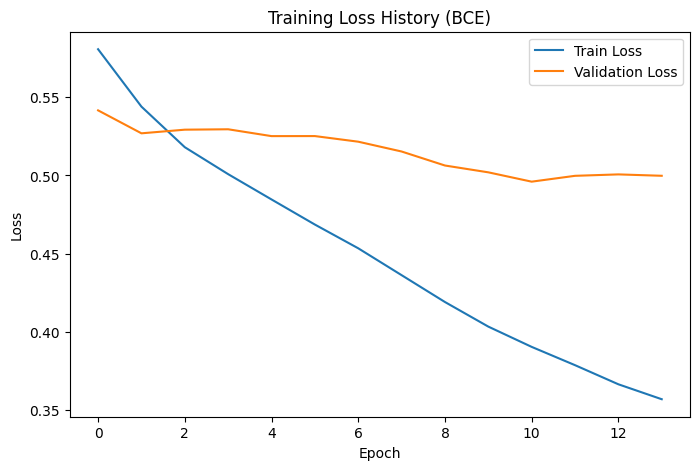


=== 추천 성능 평가  ===
케이스1[Item+Category] 성능 = NDCG@10 : 0.0231
**************************************************
케이스2[Item+Author] 테스트를 시작합니다.
총 사용자 수 (M): 9057, 총 아이템 수 (N): 26695
카테고리 수: 24, 작가 수: 16640, 출판사 수: 3043
Train Data Column List [['USER', 'ITEM', 'RATING', 'author_id']]
=== NCF 모델 학습 시작 ===
Epoch [1/20], Train Loss: 0.5875, Valid Loss: 0.5397
Epoch [2/20], Train Loss: 0.5398, Valid Loss: 0.5211
Epoch [3/20], Train Loss: 0.5114, Valid Loss: 0.5124
Epoch [4/20], Train Loss: 0.4938, Valid Loss: 0.5168
Epoch [5/20], Train Loss: 0.4830, Valid Loss: 0.5229
Epoch [6/20], Train Loss: 0.4743, Valid Loss: 0.5287
Early stopping at epoch 6 (patience=3)


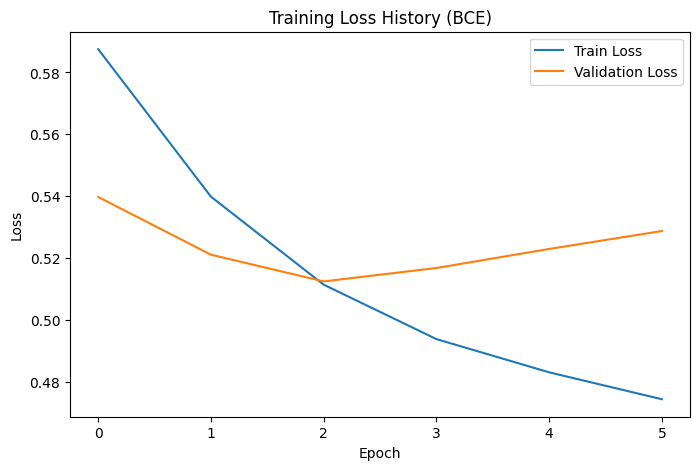


=== 추천 성능 평가  ===
케이스2[Item+Author] 성능 = NDCG@10 : 0.0216
**************************************************
케이스3[Item+Publisher] 테스트를 시작합니다.
총 사용자 수 (M): 9057, 총 아이템 수 (N): 26695
카테고리 수: 24, 작가 수: 16640, 출판사 수: 3043
Train Data Column List [['USER', 'ITEM', 'RATING', 'publisher_id']]
=== NCF 모델 학습 시작 ===
Epoch [1/20], Train Loss: 0.6034, Valid Loss: 0.5424
Epoch [2/20], Train Loss: 0.5505, Valid Loss: 0.5259
Epoch [3/20], Train Loss: 0.5230, Valid Loss: 0.5156
Epoch [4/20], Train Loss: 0.5006, Valid Loss: 0.5161
Epoch [5/20], Train Loss: 0.4852, Valid Loss: 0.5211
Epoch [6/20], Train Loss: 0.4770, Valid Loss: 0.5276
Early stopping at epoch 6 (patience=3)


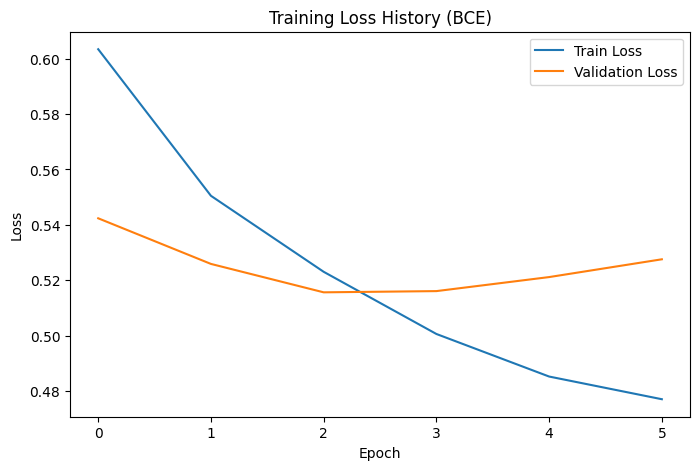


=== 추천 성능 평가  ===
케이스3[Item+Publisher] 성능 = NDCG@10 : 0.0217
**************************************************
케이스4[Item+Category+Author] 테스트를 시작합니다.
총 사용자 수 (M): 9057, 총 아이템 수 (N): 26695
카테고리 수: 24, 작가 수: 16640, 출판사 수: 3043
Train Data Column List [['USER', 'ITEM', 'RATING', 'category_id', 'author_id']]
=== NCF 모델 학습 시작 ===
Epoch [1/20], Train Loss: 0.5890, Valid Loss: 0.5431
Epoch [2/20], Train Loss: 0.5472, Valid Loss: 0.5264
Epoch [3/20], Train Loss: 0.5225, Valid Loss: 0.5243
Epoch [4/20], Train Loss: 0.4993, Valid Loss: 0.5171
Epoch [5/20], Train Loss: 0.4794, Valid Loss: 0.5164
Epoch [6/20], Train Loss: 0.4655, Valid Loss: 0.5148
Epoch [7/20], Train Loss: 0.4513, Valid Loss: 0.5128
Epoch [8/20], Train Loss: 0.4384, Valid Loss: 0.5106
Epoch [9/20], Train Loss: 0.4278, Valid Loss: 0.5062
Epoch [10/20], Train Loss: 0.4162, Valid Loss: 0.5014
Epoch [11/20], Train Loss: 0.4054, Valid Loss: 0.5009
Epoch [12/20], Train Loss: 0.3950, Valid Loss: 0.4943
Epoch [13/20], Train Loss: 0.3837

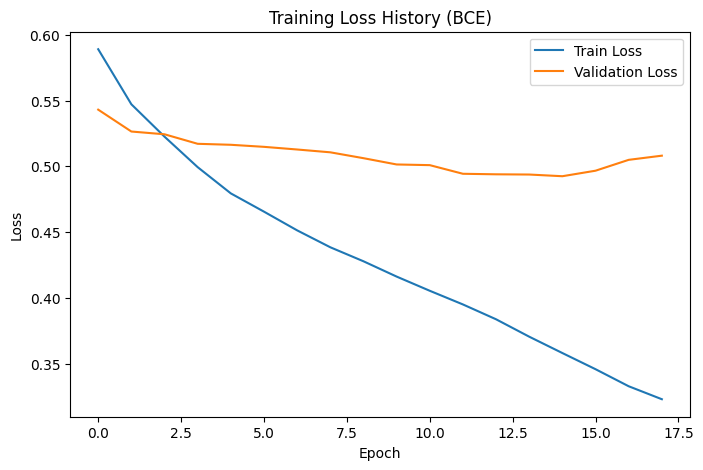


=== 추천 성능 평가  ===
케이스4[Item+Category+Author] 성능 = NDCG@10 : 0.0275
**************************************************
케이스5[Item+Category+Publisher] 테스트를 시작합니다.
총 사용자 수 (M): 9057, 총 아이템 수 (N): 26695
카테고리 수: 24, 작가 수: 16640, 출판사 수: 3043
Train Data Column List [['USER', 'ITEM', 'RATING', 'category_id', 'publisher_id']]
=== NCF 모델 학습 시작 ===
Epoch [1/20], Train Loss: 0.5858, Valid Loss: 0.5375
Epoch [2/20], Train Loss: 0.5472, Valid Loss: 0.5257
Epoch [3/20], Train Loss: 0.5276, Valid Loss: 0.5268
Epoch [4/20], Train Loss: 0.5079, Valid Loss: 0.5306
Epoch [5/20], Train Loss: 0.4882, Valid Loss: 0.5256
Epoch [6/20], Train Loss: 0.4700, Valid Loss: 0.5208
Epoch [7/20], Train Loss: 0.4559, Valid Loss: 0.5182
Epoch [8/20], Train Loss: 0.4419, Valid Loss: 0.5137
Epoch [9/20], Train Loss: 0.4306, Valid Loss: 0.5097
Epoch [10/20], Train Loss: 0.4187, Valid Loss: 0.5050
Epoch [11/20], Train Loss: 0.4090, Valid Loss: 0.5047
Epoch [12/20], Train Loss: 0.3990, Valid Loss: 0.5022
Epoch [13/20], Train 

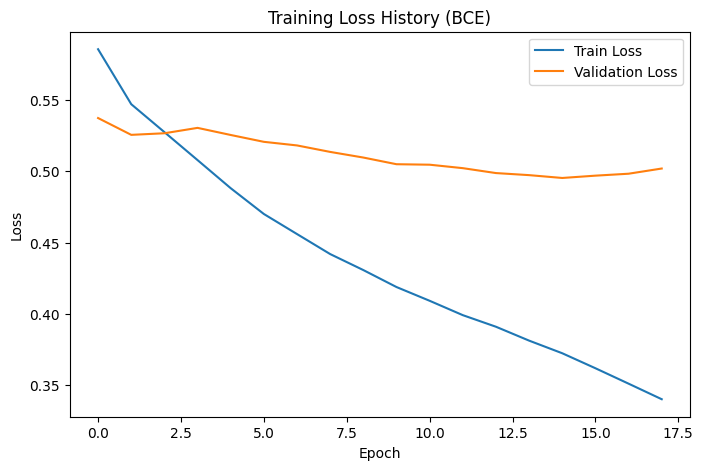


=== 추천 성능 평가  ===
케이스5[Item+Category+Publisher] 성능 = NDCG@10 : 0.0264
**************************************************
케이스6[Item+Author+Publisher] 테스트를 시작합니다.
총 사용자 수 (M): 9057, 총 아이템 수 (N): 26695
카테고리 수: 24, 작가 수: 16640, 출판사 수: 3043
Train Data Column List [['USER', 'ITEM', 'RATING', 'author_id', 'publisher_id']]
=== NCF 모델 학습 시작 ===
Epoch [1/20], Train Loss: 0.5811, Valid Loss: 0.5349
Epoch [2/20], Train Loss: 0.5375, Valid Loss: 0.5252
Epoch [3/20], Train Loss: 0.5185, Valid Loss: 0.5286
Epoch [4/20], Train Loss: 0.5047, Valid Loss: 0.5372
Epoch [5/20], Train Loss: 0.4932, Valid Loss: 0.5441
Early stopping at epoch 5 (patience=3)


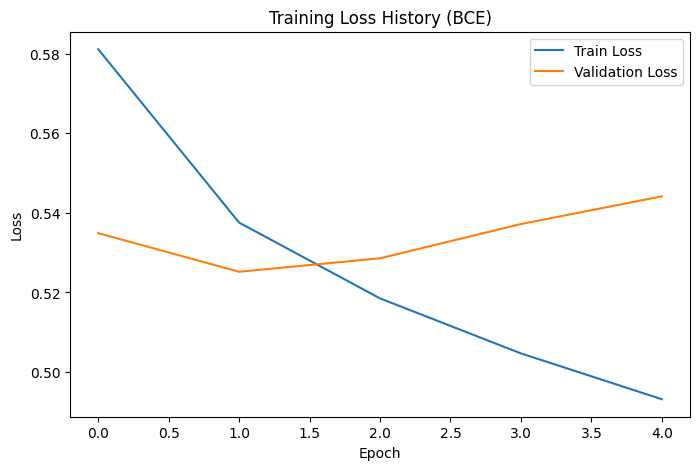


=== 추천 성능 평가  ===
케이스6[Item+Author+Publisher] 성능 = NDCG@10 : 0.0251
**************************************************
케이스7[Item+Category+Author+Publisher(Full)] 테스트를 시작합니다.
총 사용자 수 (M): 9057, 총 아이템 수 (N): 26695
카테고리 수: 24, 작가 수: 16640, 출판사 수: 3043
Train Data Column List [['USER', 'ITEM', 'RATING', 'category_id', 'author_id', 'publisher_id']]
=== NCF 모델 학습 시작 ===
Epoch [1/20], Train Loss: 0.5834, Valid Loss: 0.5349
Epoch [2/20], Train Loss: 0.5397, Valid Loss: 0.5207
Epoch [3/20], Train Loss: 0.5146, Valid Loss: 0.5167
Epoch [4/20], Train Loss: 0.4954, Valid Loss: 0.5163
Epoch [5/20], Train Loss: 0.4830, Valid Loss: 0.5174
Epoch [6/20], Train Loss: 0.4689, Valid Loss: 0.5180
Epoch [7/20], Train Loss: 0.4544, Valid Loss: 0.5183
Early stopping at epoch 7 (patience=3)


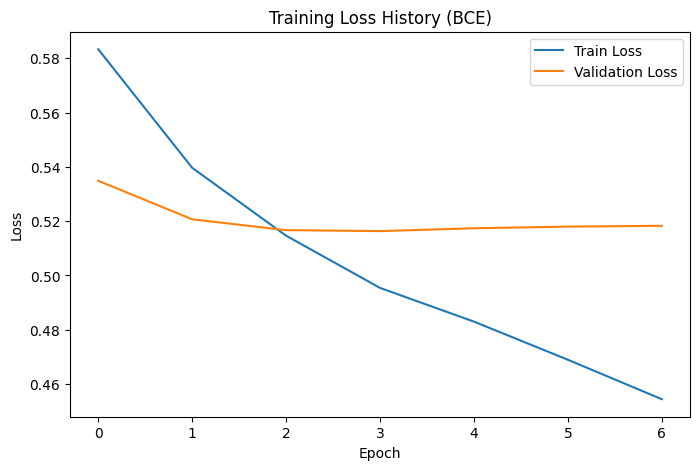


=== 추천 성능 평가  ===
케이스7[Item+Category+Author+Publisher(Full)] 성능 = NDCG@10 : 0.0236


In [10]:
# 케이스별 설정 목록
cases = [
    ("케이스1[Item+Category]",  True,  False, False),
    ("케이스2[Item+Author]",    False, True,  False),
    ("케이스3[Item+Publisher]", False, False, True),
    ("케이스4[Item+Category+Author]", True, True, False),
    ("케이스5[Item+Category+Publisher]", True, False, True),
    ("케이스6[Item+Author+Publisher]", False, True, True),
    ("케이스7[Item+Category+Author+Publisher(Full)]", True, True, True),
]

results = []  # 케이스별 성능 저장 리스트

# 케이스별 실행 루프
for case_name, use_cat, use_author, use_pub in cases:
    print("*" * 50)
    print(f"{case_name} 테스트를 시작합니다.")

    # 데이터 준비
    prepare_train_df(use_cat, use_author, use_pub)

    # 모델 학습
    ncf_model = ncf_model_train(use_cat, use_author, use_pub)

    # 성능 평가
    ndcg10 = performance_predict(ncf_model, use_cat, use_author, use_pub)

    print(f"{case_name} 성능 = NDCG@{TOP_K} : {ndcg10:.4f}")

    # 결과 저장
    results.append({
        "케이스": case_name,
        f"NDCG@{TOP_K}": ndcg10
    })


In [11]:
# 결과를 데이터프레임으로 변환
results_df = pd.DataFrame(results)

# === NDCG 기준으로 내림차순 정렬 ===
results_df = results_df.sort_values(by=f"NDCG@{TOP_K}", ascending=False).reset_index(drop=True)

print("\n" + "=" * 60)
print("📊 케이스별 성능 비교표 (내림차순 정렬)")
print("=" * 60)
print(results_df.to_string(index=False))



📊 케이스별 성능 비교표 (내림차순 정렬)
                                       케이스  NDCG@10
                케이스4[Item+Category+Author] 0.027467
             케이스5[Item+Category+Publisher] 0.026361
               케이스6[Item+Author+Publisher] 0.025097
케이스7[Item+Category+Author+Publisher(Full)] 0.023600
                       케이스1[Item+Category] 0.023053
                      케이스3[Item+Publisher] 0.021744
                         케이스2[Item+Author] 0.021647


In [12]:
# 한글 폰트 설정 (Colab용)
!apt-get -qq -y install fonts-nanum

Selecting previously unselected package fonts-nanum.
(Reading database ... 126675 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [13]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl

# 폰트 목록 갱신
fontpath = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fm.fontManager.addfont(fontpath)
plt.rc('font', family='NanumGothic')  # 기본 폰트 변경
mpl.rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지

print("NanumGothic 폰트가 설정되었습니다.")

NanumGothic 폰트가 설정되었습니다.


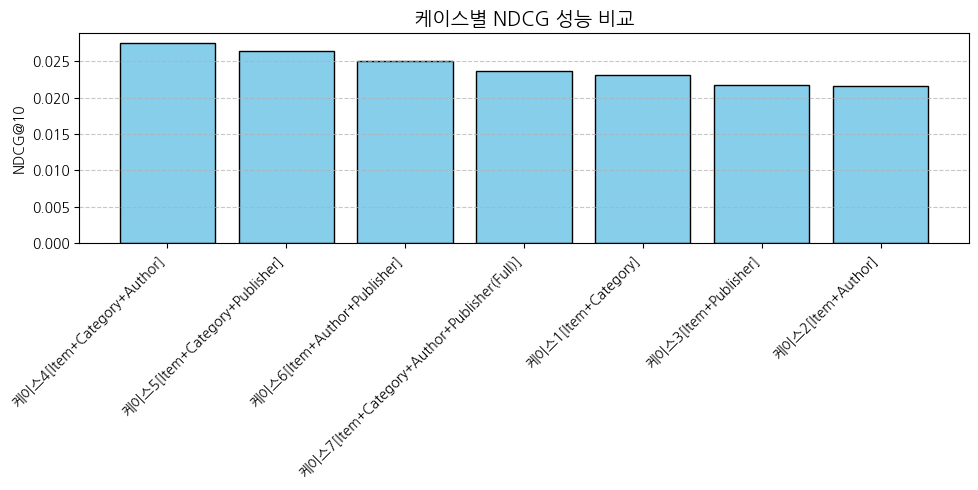

In [14]:
# === 막대그래프 시각화 ===
plt.figure(figsize=(10, 5))
plt.bar(results_df["케이스"], results_df[f"NDCG@{TOP_K}"], color='skyblue', edgecolor='black')
plt.xticks(rotation=45, ha='right')
plt.ylabel(f"NDCG@{TOP_K}")
plt.title("케이스별 NDCG 성능 비교", fontsize=14, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

(Optional) Addition vs Concatenation 방식 비교 그래프

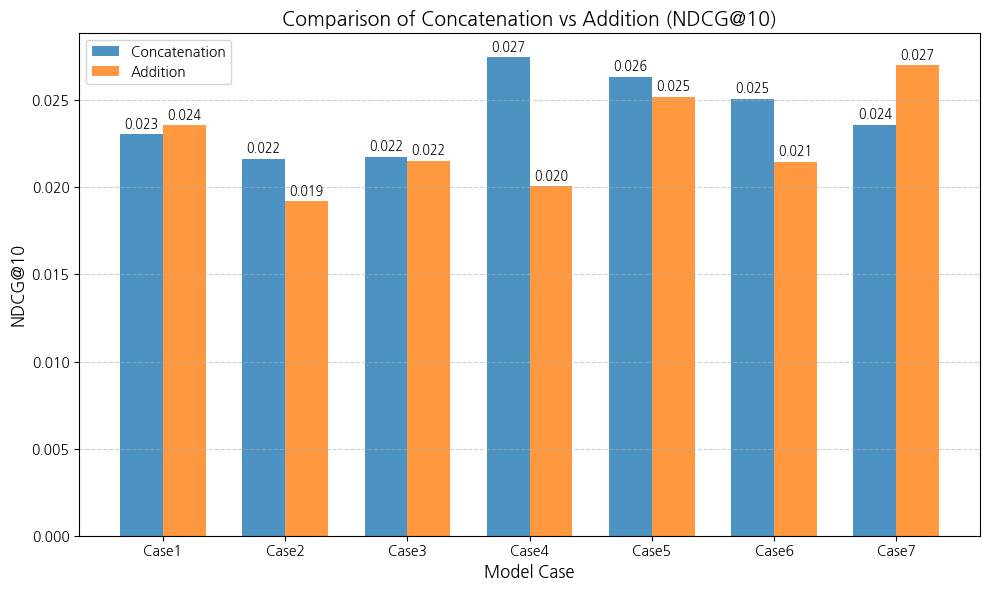

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# 데이터 입력
cases = ['Case1', 'Case2', 'Case3', 'Case4', 'Case5', 'Case6', 'Case7']
ndcg_concat = [0.023053, 0.021647, 0.021744, 0.027467, 0.026361, 0.025097, 0.023600]   # Concatenation 결과
ndcg_add = [0.023576, 0.019194, 0.021515, 0.020070, 0.025196, 0.021466, 0.027004]    # Addition 결과

x = np.arange(len(cases))
width = 0.35  # 막대 너비

# 그래프 그리기
plt.figure(figsize=(10,6))
bars1 = plt.bar(x - width/2, ndcg_concat, width, label='Concatenation', alpha=0.8)
bars2 = plt.bar(x + width/2, ndcg_add, width, label='Addition', alpha=0.8)

# 수치 표시
for bars in [bars1, bars2]:
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.0002,
                 f"{bar.get_height():.3f}", ha='center', va='bottom', fontsize=9)

# 그래프 설정
plt.title('Comparison of Concatenation vs Addition (NDCG@10)', fontsize=14)
plt.xlabel('Model Case', fontsize=12)
plt.ylabel('NDCG@10', fontsize=12)
plt.xticks(x, cases)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

# 시각화 출력
plt.show()

### 6. 실험2 결과 분석
  * 어떤 Side Info가 가장 효과적인가? - 케이스4[Item+Category+Author] 0.027467
  * Addition vs Concatenation 어느 방식이 우수한가?
    * Concatenation 방식이 전체적으로 약 8.8% 더 우수
      * Concatenation 평균 NDCG@10 = 0.024997
      * Addition 평균 NDCG@10 = 0.022974
      * 피처 수가 적을 때 (2~3개) Concatenation이 대부분 우세
        * 피처 간 정보 독립성이 유지되어, 모델이 각 피처의 latent 표현을 더 잘 학습할 수 있음.
        * 즉, 명확한 특징 분리가 필요할 때 효과적
      * 피처 수가 많을 때 (Full 조합, Case7) Addition이 우세
        * 다수 피처를 단순 연결(concat)하면 차원이 급격히 커지고 학습 효율이 떨어짐.
        * Addition은 차원을 유지한 채 feature-level 시너지를 극대화하기 때문에 정보 통합에 강함.
  * 조합 패턴이 실험 1과 다른가?
    * 최적 조합패턴이 Addition 방식은 케이스7[Item+Category+Author+Publisher(Full)]로 NDCG@10이 0.027004, Concatenation가 방식은 케이스4[Item+Category+Author] 0.027467로 서로 다르다.
    * 각 피처가 별도 차원 공간에 투영되므로, 모델은 각 피처의 독립적인 패턴을 학습할 수 있음
    * 너무 많은 피처를 넣으면 차원이 과도하게 커지고 학습 난이도 증가, 과적합 위험이 생김, 적정 수준의 피처 조합 (Case4: Item+Category+Author)이 가장 효율적
    * Category와 Author는 서로 보완적이지만, Publisher를 추가하면 잡음(정보 중복) 증가 → 성능 하락
  * 최적 조합 선정 근거
    * 최적 조합 : 케이스4[Item+Category+Author] 0.027467(가장 높은 성능)
      * Category는 사용자의 큰 취향 방향을 잡아줌
      * Author: 세밀한 선호 차이를 구체화
      * Item: 개별 경험 데이터로 구체적 보정
    * 실제 독서/콘텐츠 소비 패턴에서도 사용자는 ‘분야+작가 중심의 선택’을 하는 경우가 많으며, 출판사(브랜드)는 상대적으로 결정적 요인이 아님

